In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import Input
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

f:\python\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
f:\python\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
f:\python\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
f:\

Load Dataset

In [2]:
data_dir = pathlib.Path("../dataset")

batch_size = 32
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 810 files belonging to 3 classes.
Using 648 files for training.
Found 810 files belonging to 3 classes.
Using 162 files for validation.


Data Augmentation

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

CNN Model

In [4]:
from tensorflow.keras import Input

model = models.Sequential([
    Input(shape=(150, 150, 3)),
    data_augmentation,

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

Callback

In [5]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

target_acc = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    baseline=0.99,
    restore_best_weights=True
)

callbacks_list = [early_stop, target_acc]

In [6]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list
)

Epoch 1/30


21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8102 - loss: 0.5420 - val_accuracy: 0.8086 - val_loss: 0.4531
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8997 - loss: 0.2767 - val_accuracy: 0.9753 - val_loss: 0.0979
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9491 - loss: 0.1586 - val_accuracy: 0.9568 - val_loss: 0.1033


Visualisasi Training vs Validation Accuracy

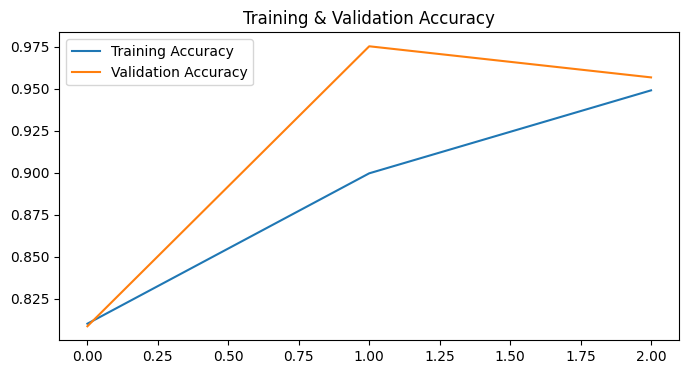

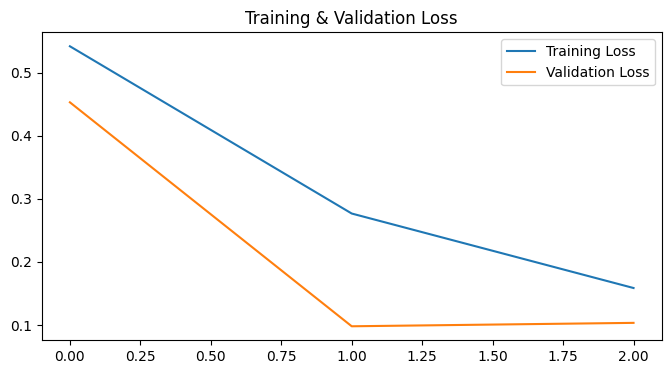

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

Simpan Model

In [11]:
save_path = os.path.join(os.getcwd(), "model.keras")
model.save(save_path)
print(f"Model disimpan di: {save_path}")

Model disimpan di: e:\DragonEye\model\model.keras


Prediksi Gambar Baru

In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tkinter import Tk, filedialog

# Buat ulang dataset untuk mengambil daftar kelas
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "../dataset",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds_raw.class_names
print("Kelas yang dikenali model:", class_names)

# ==============================
# PILIH GAMBAR DARI FILE PICKER
# ==============================
root = Tk()
root.withdraw()  # sembunyikan jendela utama tkinter

print("\nSilakan pilih file gambar yang akan diprediksi...")
img_path = filedialog.askopenfilename(
    title="Pilih Gambar untuk Prediksi",
    filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp *.webp")]
)

if img_path:
    print("File yang dipilih:", img_path)

    # Load dan preprocessing gambar
    img = image.load_img(img_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0

    # Prediksi
    pred = model.predict(x)
    predicted_class = class_names[np.argmax(pred)]
    confidence = round(np.max(pred), 4)

    print("Prediksi:", predicted_class, "| Probabilitas:", confidence)
else:
    print("Tidak ada file yang dipilih.")


Found 810 files belonging to 3 classes.
Kelas yang dikenali model: ['Mutu 1', 'Mutu 2', 'Mutu 3']

Silakan pilih file gambar yang akan diprediksi...
File yang dipilih: E:/DragonEye/dataset/Mutu 2/MT2_007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Prediksi: Mutu 2 | Probabilitas: 0.9734
